# [Paris Saclay Center for Data Science](http://www.datascience-paris-saclay.fr)

## [Cell phenotyping](http://www.ramp.studio/problems/mouse_cytometry): population identification from single cell data

_Georgios Papoutsoglou (University of Crete), Balázs Kégl (CNRS)_

## Introduction


Tissue samples are mixtures of several distinct cell types, each of which performs certain activities for the maintenance of proper tissue functioning. To carry out these activites, cells of each type are programmed to produce specific sets of membrane proteins, known as markers. These markers are usually involved in activities such as communication, adhesion, or metabolism. The specificity of a marker to an activity and, concomitantly, to a cell type makes it ideal to use for separating cells into different populations. A caveat to this task is that some surface markers will often be present on more than one cell populations.

In this context, cell phenotyping is the analysis of such heterogeneous populations of cells based on the types of proteins installed on their surfaces (phenotype). The purpose of this process is to identify the presence and proportions of the various populations of interest and enable the determination of their functions in tissues. As such, cell phenotyping has led to the significant improvement of our understanding of biological mechanisms and their association with disease. 

Single-cell technologies, such as flow/mass cytometry, are able to detect and objectively measure the abundance of cell markers in hundreds of thousands of individual cells and acquire data about dozens of them in a matter of seconds. Flow cytometry platforms, for example, have been used for decades now as a research tool to distinguish different cell types in mixed populations by measuring up to 20 markers on a cell-by-cell basis. More recently, the advent of mass cytometry has pushed this limit up to more than 40 parameters, boosting the potential resolution of phenotyping.

Until today, however, the analysis of the resulting high-dimensional datasets relies on the subjective and time-consuming _gating_, that is, a manual labeling procedure whereby cells are iteratively partitioned into populations through visual inspection by an expert using a single one-dimensional histogram or a two-dimensional scatterplot at a time. This inefficiency to handle high-dimensional data has resulted in a growing interest for the development of robust computational methods that are able to identify interesting cell populations in an automated manner. In response to such need, the goal of this challenge is to develop prediction models able to **identify cell populations from single cell mass cytometry data**.


## Data synopsis

The data is from [Samusik et al.](https://www.nature.com/nmeth/journal/v13/n6/full/nmeth.3863.html) where 38 surface markers (_features_) were measured in cells from the the bone marrow of healthy mice. The samples were analyzed and independently hand-gated by experts to identify 24 immune cell populations (_classes_).

We provide a random subset of 160K cell samples (from the [>500K publicly available](https://www.dropbox.com/sh/fx83o71jmjac554/AAA5yyvE_3dKRnvQM5VoJPLba?dl=0)).

Part of these data are saved in the files _train.csv_ and _test.csv_ as follows (<i>n_samples</i> being the number of cell samples, <i>n_feat</i> being the number of features/markers and <i>cell_type</i> being class labels):

<ul>
<li> each <b>row</b> corresponds to a cell sample</li>
<li> <b>columns 1 to 38</b> contain the abundance levels of the 38 surface markers (features). Dimensions: (n_samples, n_feat)</li>
<li><b>column 39 (<i>cell_type</i>)</b> contains the population label that each cell corresponds to according to manual gating by experts. Twenty four possible values. Dimensions: (n_samples, 1)</li>
</ul>

In [1]:
%matplotlib inline
import os
import glob
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
pd.options.display.max_columns = 40

## Exploratory data analysis

### Loading the data

In [2]:
train_filename = 'data/train.csv.gz'
data = pd.read_csv(train_filename)
y_df = data['cell type']
X_df = data.drop(['cell type'], axis=1)
X_df.head(5)

,CD45_2,Ly6G,IgD,CD11c,F480,CD3,NKp46,CD23,CD34,CD115,CD19,CD317,CD8,Ly6C,CD4,CD11b,CD27,CD16_32,SiglecF,Foxp3,B220,CD5,FceR1a,TCRgd,CCR7,Sca1,CD49b,cKit,CD150,CD25,TCRb,CD43,CD64,CD138,CD103,IgM,CD44,MHCII,replicate
0,25.322300,-0.414878,19.072302,-0.406325,8.004113,-0.226281,-0.693795,-0.502405,0.214797,-0.651973,7.006814,1.082769,0.030035,-0.296310,-0.660964,8.775167,-0.275792,15.888521,1.915515,-0.773721,21.440584,-0.833507,4.223345,-0.597891,-0.823490,17.817902,-0.160072,1.121113,-0.836055,-0.190984,-0.014425,0.783888,1.267933,1.781378,6.060744,143.941238,1.556530,433.069550,1
1,5.688966,-0.656603,1.936562,-0.338733,-0.019797,-0.710901,-0.262018,-0.707716,-0.223714,-0.343710,-0.097053,-0.267780,1.114447,-0.147502,-0.531843,35.129585,-0.285497,368.874481,19.613203,0.662094,0.018612,-0.246291,5.381715,-0.186779,-0.510146,-0.166597,103.653893,1.673315,-0.150073,-0.253155,-0.380198,-0.738412,-0.249999,-0.345677,-0.706774,-0.649381,42.760521,0.370612,1
2,16.577675,3.037624,28.618662,-0.226679,0.698736,-0.687407,-0.594474,4.009264,-0.182212,1.097268,4.403724,0.295415,-0.489098,-0.172496,-0.383780,-0.418165,-0.393277,8.735498,4.567228,3.064497,138.576797,4.661004,1.745882,-0.504398,-0.194553,35.861137,-0.782560,-0.451337,0.265020,-0.760213,-0.633052,-0.371888,4.576766,-0.538884,-0.057883,19.495363,2.384282,501.027222,1
3,12.619972,-0.135255,-0.200250,0.760378,10.994702,0.818546,-0.435885,0.548840,6.483472,1.808445,-0.004943,-0.509837,-0.203738,4.071029,0.285222,39.121468,-0.605241,94.969742,98.702667,7.406890,-0.492408,1.794403,0.737259,-0.581589,-0.105200,0.355662,8.762753,0.326256,-0.565969,-0.392343,1.538817,2.087312,2.868069,0.666312,2.692082,1.417462,235.478745,2.039408,1
4,41.787132,-0.718017,0.239240,-0.602358,1.000802,-0.478795,-0.710591,-0.145891,10.214432,3.836318,-0.619562,207.961685,7.600501,28.485512,0.368853,-0.050024,-0.166081,1.162022,0.442354,-0.546725,73.401352,0.287523,2.637238,2.915704,15.528143,1369.792358,33.122932,0.404252,-0.776655,-0.562648,-0.677347,-0.102858,-0.533857,-0.012488,-0.681483,0.039034,18.257036,30.230536,1


### Predicting cell type

The goal is to predict the cell type. Let us group the data according to the `cell type` columns:

In [3]:
counts = data.groupby('cell type').count()['CD45_2']
counts.sort_values()

cell type
HSC                                  3
gd T cells                          46
CLP                                 53
mDCs                               123
MPP                                171
Plasma Cells                       190
CMP                                257
Macrophages                        309
NK cells                           348
B-cell Frac A-C (pro-B cells)      471
Basophils                          498
MEP                                615
CD4 T cells                        705
GMP                                861
NKT cells                         1083
Non-Classical Monocytes           1130
CD8 T cells                       1462
IgM- IgD- B-cells                 1916
pDCs                              3389
IgD- IgMpos B cells               5273
Eosinophils                       7117
Intermediate Monocytes           10454
IgDpos IgMpos B cells            13582
Classical Monocytes              13944
Name: CD45_2, dtype: int64

### Some plots

#### Features densities and co-evolution
A scatterplot matrix allows us to visualize:
* on the diagonal, the density estimation for each feature
* on each of the off-diagonal plots, a scatterplot between two features. Each dot represents an instance.

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  import sys


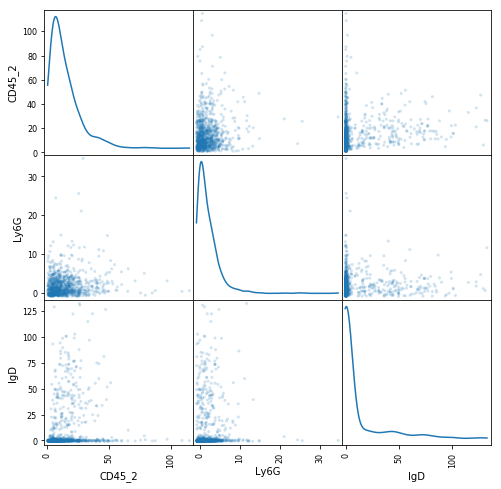

In [4]:
from pandas.tools.plotting import scatter_matrix

data_plot = data[['CD45_2', 'Ly6G', 'IgD', 'cell type']].iloc[
    np.random.choice(len(data), 1000)]

scatter_matrix(data_plot, alpha=0.2,
               figsize=(8, 8), diagonal='kde');

#### Plot the bivariate distributions and marginals of two variables 

Another way of visualizing relationships between variables is to plot their bivariate distributions.

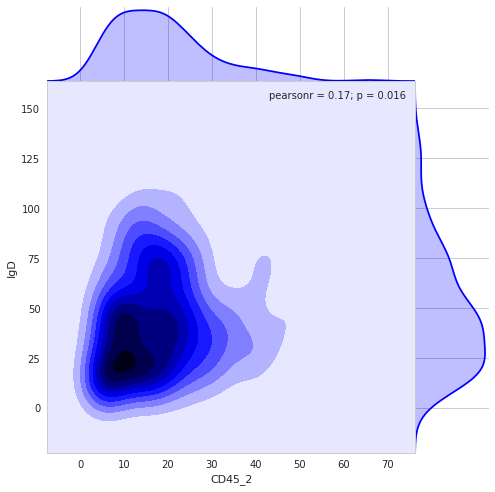

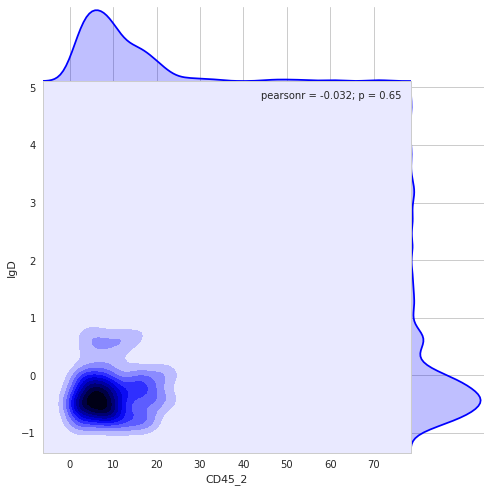

In [5]:
sns.set()
sns.set_style("whitegrid")
sns.jointplot(data_plot['CD45_2'][data_plot['cell type'] == 'IgDpos IgMpos B cells'],
              data_plot['IgD'][data_plot['cell type'] == 'IgDpos IgMpos B cells'],
              kind="kde", size=7, space=0, color="b");

sns.jointplot(data_plot['CD45_2'][data_plot['cell type'] == 'Classical Monocytes'],
              data_plot['IgD'][data_plot['cell type'] == 'Classical Monocytes'],
              kind="kde", size=7, space=0, color="b");


Jesús Bujalance Martín

# DEBUT DU TP


### Recupérer les données 

In [6]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

_target_column_name = 'cell type'
_prediction_label_names = [
    'B-cell Frac A-C (pro-B cells)', 'Basophils', 'CD4 T cells', 'CD8 T cells',
    'CLP', 'CMP', 'Classical Monocytes', 'Eosinophils', 'GMP', 'HSC',
    'IgD- IgMpos B cells', 'IgDpos IgMpos B cells', 'IgM- IgD- B-cells',
    'Intermediate Monocytes', 'MEP', 'MPP', 'Macrophages', 'NK cells',
    'NKT cells', 'Non-Classical Monocytes', 'Plasma Cells', 'gd T cells',
    'mDCs', 'pDCs']

def _read_data(path, f_name):
    data = pd.read_csv(os.path.join(path, 'data', f_name))
    y_array = data[_target_column_name]
    X_df = data.drop([_target_column_name], axis=1)
    X_df = X_df.drop(['replicate'], axis=1)
    return X_df, y_array


def get_train_data(path='.'):
    f_name = 'train.csv.gz'
    return _read_data(path, f_name)


def get_test_data(path='.'):
    f_name = 'test.csv.gz'
    return _read_data(path, f_name)

In [7]:
#Get the training data.
X_train, y_train = get_train_data()

#Get the test data.
X_test, y_test = get_test_data()

#Transform the training dataframe into numpy array.
X_train = X_train.values
X_test = X_test.values

In [8]:
# Standardisation des données
X_train = X_train - np.mean(X_train, axis=0)
X_train = X_train / np.std(X_train, axis=0)

X_test = X_test - np.mean(X_test, axis=0)
X_test = X_test / np.std(X_test, axis=0)

### Premier essai : arbre de decision

In [9]:
from sklearn import tree

param_grid = {'criterion':['gini', 'entropy'], 
              'max_depth':[5,10,15], 'min_samples_split':[2,3,4,5]}

# Initialiser un arbre
arbol = tree.DecisionTreeClassifier()

# Initialiser une validation croisée
clf = GridSearchCV(arbol, param_grid)

# Faire tourner la validation croisée sur le jeu d'entraînement
clf.fit(X_train, y_train)

print("Résultats de la cross-validation :")
print("Best: %f using %s" % (clf.best_score_,
                             clf.best_params_))

Résultats de la cross-validation :
Best: 0.995938 using {'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 2}


In [10]:
best_parameters=clf.best_params_

In [11]:
print(clf)
score = clf.score(X_test, y_test)
print("Acuracy (on test set) = ", score)
y_true, y_pred = y_test, clf.predict(X_test)
print( classification_report(y_true, y_pred) )
# print("\n CONFUSION MATRIX")
# print( confusion_matrix(y_true, y_pred) )

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [5, 10, 15], 'min_samples_split': [2, 3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)
Acuracy (on test set) =  0.96615625
                               precision    recall  f1-score   support

B-cell Frac A-C (pro-B cells)       0.78      0.86      0.82       252
                    Basophils       0.92      0.93      0.93       259
                  CD4 T cells       0.91      0.91      0.91       327
      

On obtient un score de 0.966 sur le jeu de test

### PCA

On réalise un PCA pour voir si on peut réduire les dimensions du problème. Il y a deux avantages principales :
- on a besoin de réaliser beaucoup moins de calculs
- on peut éviter de faire de l'overfitting

In [12]:
from sklearn import decomposition
pca = decomposition.PCA()
pca.fit(X_train)
X_train_pca = pca.transform(X_train)

# ratio[i] is the cumulative variance explained by the first i+1 dimensions
ratio = np.cumsum(pca.explained_variance_ratio_)

i = 0  # i+1 is the amount of components to keep
while (ratio[i] < 0.85):   # we select the first i+1 dimensions that explain 85% of the variance
    i = i + 1
X_train_pca = X_train_pca[:, :i]  # we only keep the main components

print("number of components : ", i+1)

X_test_pca = pca.transform(X_test)
X_test_pca = X_test_pca[:, :i]  # we only keep the main components


number of components :  24


In [13]:
# Learn a Decision Tree
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion=best_parameters['criterion'], splitter='best', max_depth=best_parameters['max_depth'], 
                                  min_samples_split=best_parameters['min_samples_split'], min_samples_leaf=3, 
                                  min_weight_fraction_leaf=0.0, max_features=None, 
                                  random_state=None, max_leaf_nodes=None, 
                                  min_impurity_decrease=1e-07, class_weight=None, presort=False)
clf = clf.fit(X_train_pca, y_train)

print(clf)
score = clf.score(X_test_pca, y_test)
print("Acuracy (on test set) = ", score)
y_true, y_pred = y_test, clf.predict(X_test_pca)
print( classification_report(y_true, y_pred) )
# print("\n CONFUSION MATRIX")
# print( confusion_matrix(y_true, y_pred) )

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=15,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=1e-07, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Acuracy (on test set) =  0.85184375
                               precision    recall  f1-score   support

B-cell Frac A-C (pro-B cells)       0.07      0.06      0.07       252
                    Basophils       0.77      0.73      0.75       259
                  CD4 T cells       0.81      0.84      0.83       327
                  CD8 T cells       0.94      0.94      0.94       722
                          CLP       0.13      0.07      0.09        29
                          CMP       0.48      0.43      0.45       174
          Classical Monocytes       0.90      0.93      0.91      6288
                  Eosinophils       0.89  

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


En réalisant un PCA et gardant 24 composantes on obtient des résultats nettement inférieurs qu'avec les données de base. Ce n'est donc pas une bonne idée de garder cette méthode ici.

### Feature selection

Nous allons essayer une autre méthode pour réduire la dimension du problème.
Un des principaux avantages des arbres de décision est qu'ils sont facilement interprétables. On peut utiliser cela pour ne garder que les features qui ont eu de l'importance dans la construction de notre arbre.

In [14]:
# Learn a Decision Tree
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion=best_parameters['criterion'], splitter='best', max_depth=best_parameters['max_depth'], 
                                  min_samples_split=best_parameters['min_samples_split'], min_samples_leaf=3, 
                                  min_weight_fraction_leaf=0.0, max_features=None, 
                                  random_state=None, max_leaf_nodes=None, 
                                  min_impurity_decrease=1e-07, class_weight=None, presort=False)
clf = clf.fit(X_train, y_train)

In [15]:
importances = clf.feature_importances_

In [16]:
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 15 (0.290566)
2. feature 31 (0.145769)
3. feature 2 (0.144112)
4. feature 18 (0.106538)
5. feature 20 (0.078381)
6. feature 35 (0.049713)
7. feature 13 (0.047416)
8. feature 5 (0.030895)
9. feature 11 (0.029273)
10. feature 26 (0.024795)
11. feature 8 (0.013126)
12. feature 12 (0.009489)
13. feature 27 (0.007873)
14. feature 17 (0.006145)
15. feature 22 (0.003985)
16. feature 25 (0.003713)
17. feature 4 (0.003592)
18. feature 3 (0.001519)
19. feature 14 (0.001244)
20. feature 32 (0.000562)
21. feature 10 (0.000297)
22. feature 23 (0.000201)
23. feature 0 (0.000168)
24. feature 6 (0.000160)
25. feature 30 (0.000115)
26. feature 1 (0.000072)
27. feature 24 (0.000066)
28. feature 28 (0.000062)
29. feature 16 (0.000058)
30. feature 33 (0.000038)
31. feature 36 (0.000037)
32. feature 37 (0.000023)
33. feature 19 (0.000000)
34. feature 21 (0.000000)
35. feature 9 (0.000000)
36. feature 7 (0.000000)
37. feature 29 (0.000000)
38. feature 34 (0.000000)


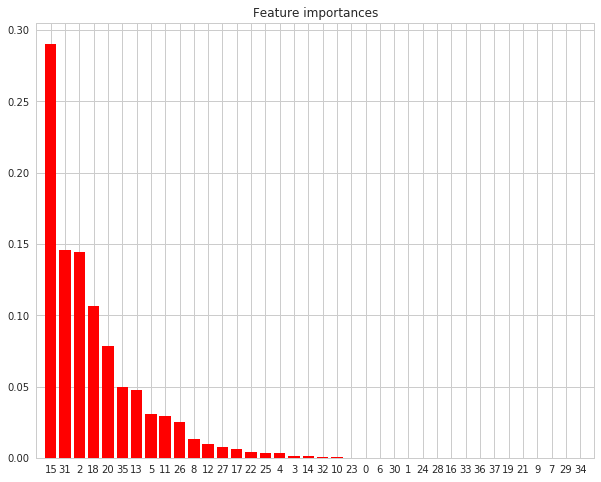

In [17]:
# Plot the feature importances of the tree
fig = plt.figure(figsize=(10, 8))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],color="r")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

On décide de garder les 19 premières features (jusqu'à 14 inclus)

In [18]:
selected_features=np.array([indices[i] for i in range(0,18)])
X_train_reduced = X_train[:,selected_features]
X_test_reduced = X_test[:,selected_features]

In [19]:
# Learn a Decision Tree
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion=best_parameters['criterion'], splitter='best', max_depth=best_parameters['max_depth'], 
                                  min_samples_split=best_parameters['min_samples_split'], min_samples_leaf=3, 
                                  min_weight_fraction_leaf=0.0, max_features=None, 
                                  random_state=None, max_leaf_nodes=None, 
                                  min_impurity_decrease=1e-07, class_weight=None, presort=False)
clf = clf.fit(X_train_reduced, y_train)


print(clf)
score = clf.score(X_test_reduced, y_test)
print("Acuracy (on test set) = ", score)
y_true, y_pred = y_test, clf.predict(X_test_reduced)
print( classification_report(y_true, y_pred) )
# print("\n CONFUSION MATRIX")
# print( confusion_matrix(y_true, y_pred) )

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=15,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=1e-07, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Acuracy (on test set) =  0.9663125
                               precision    recall  f1-score   support

B-cell Frac A-C (pro-B cells)       0.82      0.88      0.85       252
                    Basophils       0.92      0.92      0.92       259
                  CD4 T cells       0.86      0.90      0.88       327
                  CD8 T cells       0.97      0.99      0.98       722
                          CLP       0.91      1.00      0.95        29
                          CMP       0.99      0.97      0.98       174
          Classical Monocytes       1.00      1.00      1.00      6288
                  Eosinophils       1.00   

Avec ce nouveau jeu de données plus petit on obtient des résultats legèrement meilleurs (0.9663 contre 0.9661). On va donc le garder pour la suite pour tester des méthodes plus sophistiquées

## Réseau de neurones

On commence par un réseau de neurones. 

In [21]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier()

param_grid = [
  {'hidden_layer_sizes': [(5,), (10,), (15,)], 
   'learning_rate_init':[0.01, 0.05, 0.1],
   'alpha': [0.00001, 0.0001, 0.001, 0.01]}
 ]

clf = GridSearchCV(mlp, param_grid)

clf.fit(X_train_reduced, y_train)

print("Résultats de la cross-validation :")
print("Best: %f using %s" % (clf.best_score_,
                             clf.best_params_))


Résultats de la cross-validation :
Best: 0.991781 using {'alpha': 0.0001, 'hidden_layer_sizes': (15,), 'learning_rate_init': 0.01}


In [22]:
print(clf)
score = clf.score(X_test_reduced, y_test)
print("Acuracy (on test set) = ", score)
y_true, y_pred = y_test, clf.predict(X_test_reduced)
print( classification_report(y_true, y_pred) )
# print("\n CONFUSION MATRIX")
# print( confusion_matrix(y_true, y_pred) )

GridSearchCV(cv=None, error_score='raise',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'hidden_layer_sizes': [(5,), (10,), (15,)], 'learning_rate_init': [0.01, 0.05, 0.1], 'alpha': [1e-05, 0.0001, 0.001, 0.01]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)
Acuracy (on test set) =  0.96921875
                               precision    recall  f1-score   support

B-cell Frac A-C (pro-B cells)       0.94      0.71      0.81       252
                    Basophils    

On obtient un score de 0.969, qui est donc meilleur que l'arbre de décision, mais assez proche. On va donc exploiter plus l'idée de l'arbre en utilisant une foret aléatoire

### Random forest

In [23]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {'n_estimators':[50, 100], 'max_features':['auto', 'log2', None], 'max_depth':[10, 15]}

rf = RandomForestClassifier()

# Initialiser une validation croisée
clf = GridSearchCV(rf, param_grid)

# Faire tourner la validation croisée sur le jeu d'entraînement
clf=clf.fit(X_train_reduced, y_train)

print("Résultats de la cross-validation :")
print("Best: %f using %s" % (clf.best_score_,
                             clf.best_params_))

Résultats de la cross-validation :
Best: 0.997000 using {'max_depth': 15, 'max_features': 'log2', 'n_estimators': 100}


In [24]:
# Evaluate acuracy on test data
print(clf)
score = clf.score(X_test_reduced, y_test)
print("Acuracy (on test set) = ", score)
y_true, y_pred = y_test, clf.predict(X_test_reduced)
print( classification_report(y_true, y_pred) )
# print("\n CONFUSION MATRIX")
# print( confusion_matrix(y_true, y_pred) )

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [50, 100], 'max_features': ['auto', 'log2', None], 'max_depth': [10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)
Acuracy (on test set) =  0.97025
                               precision    recall  f1-score   support

B-cell Frac A-C (pro-B cells)       0.95      0.88      0.91       252
                    Basophils       1.00      0.95      0.97       259
              

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


On obtient un score un peu meilleur, 0.970. On va utiliser l'algorithme adaboost basée sur des forêts aléatoire pour voir si on peut améliorer le reśultat

### ADABOOST CLASSIFIER

Weak_learner: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Weights of weak classifiers:  [5.53366225 4.95338513 4.787168   5.20996342 4.81961775 4.65988391
 5.23216678 4.80150257 4.79726491 4.85314412 5.06290186 5.13836546
 4.82764453 4.67343757 5.18818302 4.64012792 5.15962656 4.74795459
 5.23443902 5.54943488 4.89254615 5.01513584 4.85792365 4.75913665
 5.29379519 4.88376276 4.50608186 5.26965884 5.20675797 4.75882527
 5.35319604 5.03374327 4.95832003 4.52810021 4.94515652 5.10604555
 4.89983188 4.6277304  4.61717183 5.18116599 4.85094439 5.2204625
 5.24486311 4.94327207 5.18894544 5.39568957 5.22824888 5.09019611
 4.

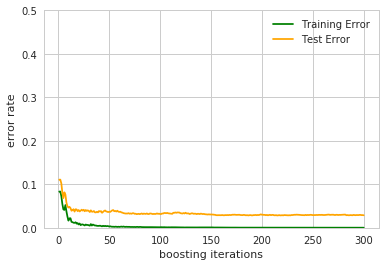

n_estimators= 300
Acuracy (on test set) =  0.97115625
                               precision    recall  f1-score   support

B-cell Frac A-C (pro-B cells)       0.93      0.88      0.91       252
                    Basophils       1.00      0.96      0.98       259
                  CD4 T cells       0.98      0.99      0.98       327
                  CD8 T cells       1.00      1.00      1.00       722
                          CLP       1.00      0.76      0.86        29
                          CMP       0.99      1.00      1.00       174
          Classical Monocytes       1.00      1.00      1.00      6288
                  Eosinophils       0.99      1.00      0.99      3186
                          GMP       1.00      0.96      0.98       416
                          HSC       0.00      0.00      0.00         1
          IgD- IgMpos B cells       0.79      1.00      0.88      2908
        IgDpos IgMpos B cells       1.00      1.00      1.00      6588
            IgM- IgD- 

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [25]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

# Create and train an adaBoost classifier using SMALL Decision Trees as weak classifiers
#weak_learner = tree.DecisionTreeClassifier(max_depth=4)
weak_learner = RandomForestClassifier(n_estimators=10, max_depth=5)
clf = AdaBoostClassifier(weak_learner, n_estimators=300, learning_rate=1.0, algorithm='SAMME', 
                         random_state=None)
clf = clf.fit(X_train, y_train)
print("Weak_learner:", clf.base_estimator)
print("Weights of weak classifiers: ", clf.estimator_weights_)
      
# Plot training curves (error = f(iterations))
n_iter = clf.n_estimators
from sklearn.metrics import zero_one_loss
ada_train_err = np.zeros((clf.n_estimators,))
for i, y_pred in enumerate(clf.staged_predict(X_train)):
    ada_train_err[i] = zero_one_loss(y_pred, y_train)
ada_test_err = np.zeros((clf.n_estimators,))
for i, y_pred in enumerate(clf.staged_predict(X_test)):
    ada_test_err[i] = zero_one_loss(y_pred, y_test)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.arange(n_iter) + 1, ada_train_err,
        label='Training Error',
        color='green')
ax.plot(np.arange(n_iter) + 1, ada_test_err,
        label='Test Error',
        color='orange')
ax.set_ylim((0.0, 0.5))
ax.set_xlabel('boosting iterations')
ax.set_ylabel('error rate')
leg = ax.legend(loc='upper right', fancybox=True)
plt.show()

# Evaluate acuracy on test data
print("n_estimators=", clf.n_estimators)
score = clf.score(X_test, y_test)
print("Acuracy (on test set) = ", score)
y_true, y_pred = y_test, clf.predict(X_test)
print( classification_report(y_true, y_pred) )
# print("\n CONFUSION MATRIX")
# print( confusion_matrix(y_true, y_pred) )

On obtient un score encore meilleur, 0.971

### Conclusion

On a obtenu un résultat de 0.971. On l'a obtenu avec l'algorithme adaboost en utilisant des forêts aléatoires comme weak learner, après avoir fait une feature selection ne gardant que 19 features sur 38. Si on avait un jeu de données plus grand, et avec le même nombre de representats pour chaque classe, je pense qu'on aurait pu atteindre des meilleurs résultats. Par exemple, on aurait pu utiliser une nested cross-validation sur tout l'ensemble de données (train set + test set) pour pouvoir apprendre sur plus de données tout en ayant des tests non biaisés. On aurait pu essayer aussi d'autres algorithmes, comme les réseaux de neurones convolutionnels, que je n'ai pas utilisé car ma machine est trop lente.
Mais le résultat obtenu est quand même satisfaisant.